In [38]:
import os
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pickle

### Load Data

In [39]:
folder_FUS_FL = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT"
os.chdir(folder_FUS_FL)


dict_perLoc_best = pickle.load(
    open("pair_correlation_FUSperLoc_RNAperLoc_best/PairCorr-DataDict.p", "rb")
)
dict_perLoc_better = pickle.load(
    open("pair_correlation_FUSperLoc_RNAperLoc_better/PairCorr-DataDict.p", "rb")
)
dict_perTrack_best = pickle.load(
    open("pair_correlation_FUSperTrack_RNAperTrack_best/PairCorr-DataDict.p", "rb")
)
dict_perTrack_better = pickle.load(
    open("pair_correlation_FUSperTrack_RNAperTrack_better/PairCorr-DataDict.p", "rb")
)

switch_perLoc_perTrack = "perLoc"
# switch_perLoc_perTrack = "perTrack"

In [40]:
# Assume the following parameters are the same for all PairCorr-DataDict.p
nm_per_pxl = dict_perLoc_best['nm_per_pxl']
r_max_nm = dict_perLoc_best['r_max_nm']
ringwidth_nm = dict_perLoc_best['ringwidth_nm']
dr_slidingrings_nm = dict_perLoc_best['dr_slidingrings_nm']
bins = dict_perLoc_best['bins']

In [41]:
dict_perLoc_best.keys()

dict_keys(['filenames_FUS', 'filenames_RNA', 'lst_N_locations_FUS', 'lst_N_locations_RNA', 'lst_cross_pair_correlation', 'lst_autoFUS_pair_correlation', 'nm_per_pxl', 'r_max_nm', 'ringwidth_nm', 'dr_slidingrings_nm', 'bins'])

### Functions

In [42]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std

def critical_system_PCF(r, A, characteristic_size):
     Gr = 1 + A * np.exp(- r / characteristic_size)
     return Gr

### autoFUS individual

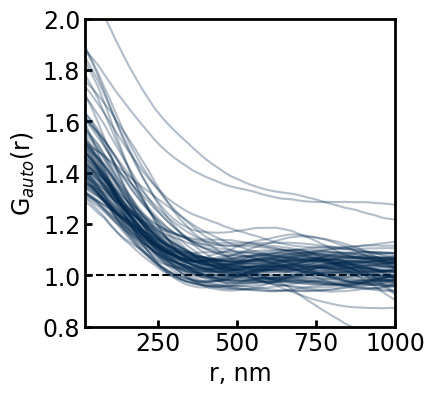

In [43]:
# Plot individual curves for perLoc
if switch_perLoc_perTrack == "perLoc":
    lst_PCF_per_condensate = (
        dict_perLoc_best["lst_autoFUS_pair_correlation"]
        + dict_perLoc_better["lst_autoFUS_pair_correlation"]
    )
elif switch_perLoc_perTrack == "perTrack":
    lst_PCF_per_condensate = (
        dict_perTrack_best["lst_autoFUS_pair_correlation"]
        + dict_perTrack_better["lst_autoFUS_pair_correlation"]
    )

plt.figure(figsize=(4, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#00274c", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### autoFUS weighted mean, STD

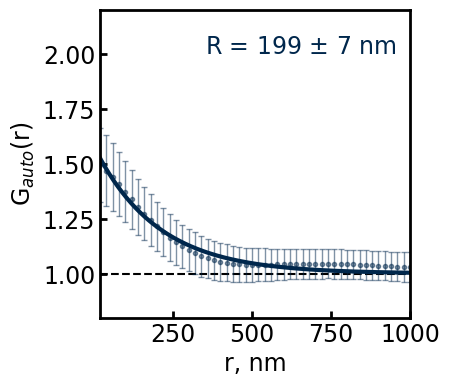

In [44]:
# Calculate the weighted mean, STD, SEM
if switch_perLoc_perTrack == "perLoc":
    lst_PCF_per_condensate = (
        dict_perLoc_best["lst_autoFUS_pair_correlation"]
        + dict_perLoc_better["lst_autoFUS_pair_correlation"]
    )
    lst_N_locations = (
        dict_perLoc_best["lst_N_locations_FUS"]
        + dict_perLoc_better["lst_N_locations_FUS"]
    )
elif switch_perLoc_perTrack == "perTrack":
    lst_PCF_per_condensate = (
        dict_perTrack_best["lst_autoFUS_pair_correlation"]
        + dict_perTrack_better["lst_autoFUS_pair_correlation"]
    )
    lst_N_locations = (
        dict_perTrack_best["lst_N_locations_FUS"]
        + dict_perTrack_better["lst_N_locations_FUS"]
    )

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)


# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, characteristic_size = popt
A_error, characteristic_size_error = np.sqrt(np.diag(pcov))

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 4))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt=".",
    color="#00274c",
    ecolor="#00274c",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, characteristic_size)
plt.plot(r_fit, gr_fit, c="#00274c", lw=3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2.2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.text(
    350,
    2,
    "R = "
    + str(round(characteristic_size))
    + r" $\pm$ "
    + str(round(characteristic_size_error))
    + " nm",
    fontsize=17,
    color="#00274c",
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross individual

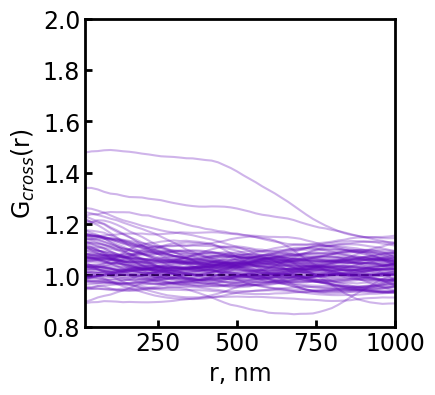

In [45]:
# Plot individual curves for perLoc
if switch_perLoc_perTrack == "perLoc":
    lst_PCF_per_condensate = (
        dict_perLoc_best["lst_cross_pair_correlation"]
        + dict_perLoc_better["lst_cross_pair_correlation"]
    )
elif switch_perLoc_perTrack == "perTrack":
    lst_PCF_per_condensate = (
        dict_perTrack_best["lst_cross_pair_correlation"]
        + dict_perTrack_better["lst_cross_pair_correlation"]
    )

plt.figure(figsize=(4, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross weighted mean + STD

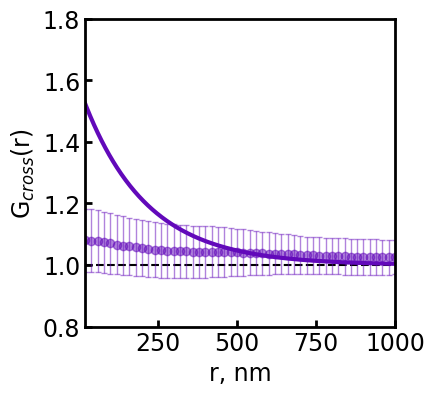

In [46]:
# Calculate the weighted mean, STD, SEM
if switch_perLoc_perTrack == "perLoc":
    lst_PCF_per_condensate = (
        dict_perLoc_best["lst_cross_pair_correlation"]
        + dict_perLoc_better["lst_cross_pair_correlation"]
    )
    lst_N_locations_FUS = (
        dict_perLoc_best["lst_N_locations_FUS"]
        + dict_perLoc_better["lst_N_locations_FUS"]
    )
    lst_N_locations_RNA = (
        dict_perLoc_best["lst_N_locations_RNA"]
        + dict_perLoc_better["lst_N_locations_RNA"]
    )
    lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

elif switch_perLoc_perTrack == "perTrack":
    lst_PCF_per_condensate = (
        dict_perTrack_best["lst_cross_pair_correlation"]
        + dict_perTrack_better["lst_cross_pair_correlation"]
    )
    lst_N_locations_FUS = (
        dict_perTrack_best["lst_N_locations_FUS"]
        + dict_perTrack_better["lst_N_locations_FUS"]
    )
    lst_N_locations_RNA = (
        dict_perTrack_best["lst_N_locations_RNA"]
        + dict_perTrack_better["lst_N_locations_RNA"]
    )
    lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]


weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)


# Plot weighted mean curves + STD
plt.figure(figsize=(4, 4))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, characteristic_size)
plt.plot(r_fit, gr_fit, c="#6209ba", lw=3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 1.8)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)